# This notebook will reproduce the plot in Fig. 3 left of 2407.14460

### - Start importing all libraries

In [1]:
# Import global libs
import sys
import time
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

sys.path.append('../')

# Import local libs
import examples_utils as eu
import fastPTA.utils as ut
from fastPTA.signals import get_signal_model
from fastPTA.Fisher_code import compute_fisher

### - Constants to generate the Fisher results

In [2]:
# Total observation time in years
T_obs_yrs = 16.03

# Number of frequencies used in the analysis
n_frequencies = 30

# Number of pulsars used in the analysis
n_pulsars = 68

# Maximum value of l used in the analysis
l_max = 6  

# Define the signal model
signal_model = get_signal_model('power_law')

# The analysis assumes a power law template, specify here the input parameters
log_amplitude = -7.1995  # log amplitude
tilt = 2.0  # Tilt

# Number of catalog realizations to be generated
N_realizations = 30

# Whether you want to regenerate the fisher data
regenerate_fisher_data = False

# Whether you want to regenerate the sample data
regenerate_sample_data = False

# Name of the outfile, no need for the extension
# (will be stored in generated_data/)
outname = "NGlike"

### - Constants for the plots

In [3]:
# Confidence level for the Cls
limit_cl = 0.95

# Number of samples used for each realization
n_points = int(1e4)

# Number of catalog realizations used in the analysis.
# If larger than N_realizations taxes that as max
N_realizations_in_plot = 32

# Number of cores to be used for parallel computations
num_cores = cpu_count()

### - Build the injection 

In [4]:
# All multipoles here are set to zero
signal_lm = (
    1e-30 / np.sqrt(4 * np.pi) * np.ones(ut.get_n_coefficients_real(l_max))
)

# The monopole is set to 1 (with the right normalization)
signal_lm[0] = 1.0 / np.sqrt(4 * np.pi)

# The two parameters characterizing the signal in frequency
signal_parameters = np.array([log_amplitude, tilt])

# Len of the parameters used in the analysis
shape_params = len(signal_parameters)

# The monopole is not included in the fisher analysis since it's degenerate
means = np.concatenate((signal_parameters, signal_lm[1:]))

# The number of parameters used in the fisher analysis
n_params = len(means)

### - Define the inputs for compute_fisher

In [5]:
# Dictionary with the kwargs to generete the pulsar catalogs
generate_catalog_kwargs = {
    "n_pulsars": n_pulsars,
    "save_catalog": True,
    "use_ng_positions" : True,
    **eu.EPTAlike,
}

# Dictionary with the kwargs to generate noise and orf tensors 
get_tensors_kwargs = {
    "path_to_pulsar_catalog": "pulsar_configurations/EPTA68.txt",
    "add_curn": False,
    "regenerate_catalog": True,
    "anisotropies": True,
    "l_max": l_max,
}

# Dictionary with the kwargs to generate the fisher matrix
fisher_kwargs = {
    "T_obs_yrs": T_obs_yrs,
    "n_frequencies": n_frequencies,
    "signal_model": signal_model,
    "signal_parameters": signal_parameters,
    "signal_lm": signal_lm,
}

### - Try to load the fisher data, if not there generate

In [6]:
try:
    if regenerate_fisher_data:
        raise FileNotFoundError("Flag forces regeneration")

    fisher = np.load("generated_data/" + outname + ".npz")["all_fishers"]

except FileNotFoundError:
    fisher = np.zeros((N_realizations, n_params, n_params))

    for index in tqdm.tqdm(range(N_realizations)):
        res = compute_fisher(
            **fisher_kwargs,
            get_tensors_kwargs=get_tensors_kwargs,
            generate_catalog_kwargs=generate_catalog_kwargs
        )[-1]

        # Delete the monopole since it's degenerate
        fisher[index] = np.delete(np.delete(res, 2, axis=-1), 2, axis=-2)

    np.savez("generated_data/" + outname + ".npz", all_fishers=fisher)

### - Try to load the limits, if not there generate <br /> NB with current settings a run can take order 7 minutes

In [12]:
try:
    if regenerate_sample_data:
        raise FileNotFoundError("Flag forces regeneration")
    
    Cl_limits = np.loadtxt("generated_data/Cl_limits_" + outname + ".dat")
    Cl_limits_prior = np.loadtxt(
        "generated_data/Cl_limits_prior_" + outname + ".dat"
    )

    if len(Cl_limits) != N_realizations:
        raise FileNotFoundError("Flag forces regeneration")

except FileNotFoundError:
    cov = ut.compute_inverse(fisher)

    for j in range(min(N_realizations_in_plot, N_realizations)):
        arg_grid = [
            [means, cov[j]]
            for j in range(min(N_realizations_in_plot, N_realizations))
        ]

    def get_Cl_wrapper(parameters):
        return ut.get_Cl_limits(
            *parameters,
            shape_params,
            n_points=n_points,
            limit_cl=limit_cl,
            max_iter=100,
            prior=5.0 / (4.0 * np.pi)
        )

    start = time.time()
    with Pool(num_cores) as p:
        res = np.array(p.map(get_Cl_wrapper, arg_grid, chunksize=1))
    end = time.time()
    print("Time to compute Cl limts:", end - start)

    Cl_limits = res[:, 0]
    Cl_limits_prior = res[:, 1]

    Cl_limits_prior = Cl_limits_prior[np.isfinite(Cl_limits_prior[:, 0])]
    np.savetxt("generated_data/Cl_limits_" + outname + ".dat", Cl_limits)
    np.savetxt(
        "generated_data/Cl_limits_prior_" + outname + ".dat", Cl_limits_prior
    )

# Normalize with C0
Cl_limits *= 4 * np.pi 
Cl_limits_prior *= 4 * np.pi 

/home/pieroni/.pyenv/versions/3.10.8/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/pieroni/.pyenv/versions/3.10.8/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Time to compute Cl limts: 436.2686126232147


### - Compute mean and quantiles among the realizations

In [8]:
# Compute the mean and the errors on the Cls without prior 
mean_Cl_limits = np.mean(Cl_limits, axis=0)
err_low_Cl_limits = mean_Cl_limits - np.quantile(Cl_limits, 0.025, axis=0)
err_high_Cl_limits = np.quantile(Cl_limits, 0.975, axis=0) - mean_Cl_limits

# Compute the mean and the errors on the Cls with the prior 
mean_Cl_limits_prior = np.mean(Cl_limits_prior, axis=0)
err_low_Cl_limits_prior = mean_Cl_limits_prior - np.quantile(
    Cl_limits_prior, 0.025, axis=0
)
err_high_Cl_limits_prior = (
    np.quantile(Cl_limits_prior, 0.975, axis=0) - mean_Cl_limits_prior
)

### - Compute the limits due to the prior only

In [9]:
data_prior = np.random.uniform(
    -5.0 / (4.0 * np.pi), 5.0 / (4.0 * np.pi), (n_points, len(means[1:]))
)

Cl_prior_values = ut.get_CL_from_real_clm(data_prior.T)[1:]

Cl_prior = np.quantile(Cl_prior_values, limit_cl, axis=-1)

Cl_prior *= 4 * np.pi

print("Just prior:")
print("C_l / C_0 =", Cl_prior)

Just prior:
C_l / C_0 = [1.26398407 1.11928078 1.0466056  0.99687673 0.96484063 0.94688236]


### - Load the NANOgrav constraints

In [10]:
limits_NG = np.loadtxt("data_paper_2/limits_Cl_powerlaw_lin_ng15.dat")[:, 1]

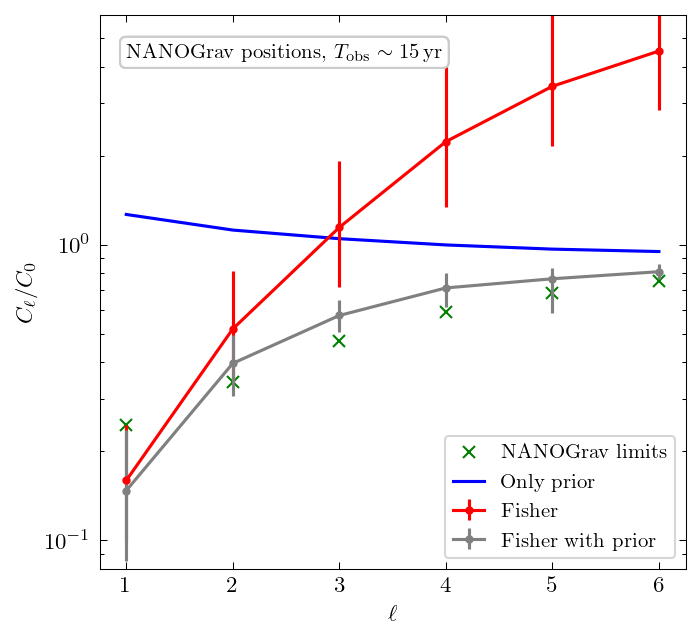

In [11]:
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=11)
plt.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath} \usepackage{amssymb}"
)
fig = plt.figure(figsize=(0.4 * 12.0, 0.4 * 11.0), dpi=150, edgecolor="white")
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(
    axis="both", which="both", labelsize=11, direction="in", width=0.5
)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")


ax.semilogy(
    np.arange(1, l_max + 1),
    limits_NG,
    label=r"NANOGrav limits",
    color="green",
    marker="x",
    lw=0,
)

ax.semilogy(
    np.arange(1, l_max + 1),
    Cl_prior,
    "blue",
    label=r"Only prior",
)

ax.errorbar(
    np.arange(1, l_max + 1),
    mean_Cl_limits,
    yerr=(err_low_Cl_limits, err_high_Cl_limits),
    color="red",
    label=r"Fisher",
    marker=".",
)

ax.errorbar(
    np.arange(1, l_max + 1),
    mean_Cl_limits_prior,
    yerr=(err_low_Cl_limits_prior, err_high_Cl_limits_prior),
    color="grey",
    label=r"Fisher with prior",
    marker=".",
)


plt.legend(loc="lower right", fontsize=10, handlelength=1.5)
props = dict(
    boxstyle="round",
    facecolor="white",
    alpha=1,
    linewidth=1,
    edgecolor="0.8",
)

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(0.5)

    ax.text(
        1,
        4.8e0,
        r"NANOGrav positions, $T_\mathrm{obs} \sim 15 \, \mathrm{yr}$",
        horizontalalignment="left",
        fontsize=10,
        verticalalignment="top",
        bbox=props,
        linespacing=1.4,
    )

    # set x axis label
    ax.set_xlabel(r"$\ell$")
    ax.set_ylabel(r"$C_\ell / C_0$")
    plt.ylim(0.8e-1, 6e0)

    plt.tight_layout()
    plt.savefig("plots/Cl_sens_lim_ng_like.pdf")